## Code

### Please find the 3 correct and 3 incorrect predictions at the bottom of this notebook. Thanks!

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import io
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import pdb
import matplotlib
import matplotlib.pyplot as plt

BATCH_SIZE = 32

In [16]:
device = torch.device("cuda:0")
print(device)

cuda:0


### Helper functions for each step in the pipeline

In [17]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    print(n, d)
    i = 0
    for line in fin:
        if i == VOCAB_SIZE:
            break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
        i += 1
    return data

In [18]:
from collections import Counter
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1
VOCAB_SIZE = 50000

def build_vocab():
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    word_vectors = pkl.load(open("fasttext_word_vectors.p", "rb"))
    id2token = list(word_vectors.keys())
    token2id = dict(zip(word_vectors, range(2,2+len(word_vectors)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return word_vectors, token2id, id2token

In [19]:
def convert_labels_to_integers(data_label):
    for i in range(len(data_label)):
        if data_label[i] == "contradiction":
            data_label[i] = 0
        elif data_label[i] == "entailment":
            data_label[i] = 1
        elif data_label[i] == "neutral":
            data_label[i] = 2
    return data_label

In [20]:
def verify_order(sent1_data, sent2_data, data_label):
    i = random.randint(1, len(sent1_data))
    print(sent1_data[i])
    print(sent2_data[i])
    print(data_label[i])

In [21]:
# Word tokenize each entry in a list of sentences
def tokenize(sentence_list):
    return [word_tokenize(sentence_list[i]) for i in range(len(sentence_list))]

In [22]:
# "one-hot encode": convert each token to id in vocabulary vector (token2id)
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data 

### Creating vocabulary & embedding matrix from FastText

In [23]:
word_vectors, token2id, id2token = build_vocab()

In [24]:
_weights = np.array(list(word_vectors.values()))
pad_vec = np.zeros((1, 300))
unk_vec = np.random.randn(1, 300) * 0.01
pad_unk_vecs = np.vstack((pad_vec, unk_vec))
_WEIGHTS = np.vstack((pad_unk_vecs, _weights))
_WEIGHTS.shape

(50002, 300)

### Function to pre-process data for TwoSentenceModel
#### Shuffle, word tokenize, one-hot index into vocabulary

In [25]:
def data_pipeline(sent1s, sent2s, labels, verify=True):
    labels = convert_labels_to_integers(labels)
    seed = random.randint(1, 100)
    print("Random seed for shuffling: {}".format(seed))
    random.Random(seed).shuffle(sent1s)
    random.Random(seed).shuffle(sent2s)
    random.Random(seed).shuffle(labels)
    
    print("\nVerifying that the data and label match after shuffling")
    if verify:
        verify_order(sent1s, sent2s, labels)
        verify_order(sent1s, sent2s, labels)
          
    print("\nTokenizing sentence 1 list...")    
    sent1s_tokenized = tokenize(sent1s)
    print("done!")
    print("\nTokenizing sentence 2 list... ")  
    sent2s_tokenized = tokenize(sent2s)
    print("done!")
    
    print("\nOne-hot encoding words for sentence 1 list...")  
    sent1s_indices = token2index_dataset(sent1s_tokenized)
    print("done!")
    print("\nOne-hot encoding words for sentence 2 list...")  
    sent2s_indices = token2index_dataset(sent2s_tokenized)
    print("done!")
    
    return (sent1s_indices, sent2s_indices, labels)

### DataLoader

In [26]:
# MAX_SENTENCE_LENGTH = 30

import numpy as np
import torch
from torch.utils.data import Dataset

class TwoSentencesDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    """
    
    def __init__(self, sent1_data_list, sent2_data_list, target_list):
        """
        @param sent1_data_list: list of sentence1's (index matches sentence2's and target_list below)
        @param sent2_data_list: list of sentence2's
        @param target_list: list of correct labels

        """
        self.sent1_data_list = sent1_data_list
        self.sent2_data_list = sent2_data_list
        self.target_list = target_list
        assert (len(self.sent1_data_list) == len(self.target_list) and len(self.sent2_data_list) == len(self.target_list))

    def __len__(self):
        return len(self.sent1_data_list)
        
    def __getitem__(self, key):
        ###
        ### Returns [[sentence, 1, tokens], [sentence, 2, tokens]]
        ###
        """
        Triggered when you call dataset[i]
        """
        sent1_tokens_idx = self.sent1_data_list[key][:MAX_SENTENCE_LENGTH]
        sent2_tokens_idx = self.sent2_data_list[key][:MAX_SENTENCE_LENGTH]
        combined_tokens_idx = [sent1_tokens_idx, sent2_tokens_idx]
        label = self.target_list[key]
        return [combined_tokens_idx, len(sent1_tokens_idx), len(sent2_tokens_idx), label]

def twosentences_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sent1_data_list = []
    sent2_data_list = []
    sent1_length_list = []
    sent2_length_list = []
    label_list = []
    combined_data_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[3])
        sent1_length_list.append(datum[1])
        sent2_length_list.append(datum[2])
    # padding
    for datum in batch:
        padded_vec_1 = np.pad(np.array(datum[0][0]), pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        padded_vec_2 = np.pad(np.array(datum[0][1]), pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        combined_data_list.append([padded_vec_1, padded_vec_2])
    return [torch.from_numpy(np.array(combined_data_list)), 
            torch.LongTensor(sent1_length_list), torch.LongTensor(sent2_length_list), torch.LongTensor(label_list)]

### Train dataset creation

In [27]:
snli_train = pd.read_csv('snli_train.tsv', sep='\t')
TRAIN_SIZE = 100000

sent1_data = list(snli_train["sentence1"])[:TRAIN_SIZE]
sent2_data = list(snli_train["sentence2"])[:TRAIN_SIZE]
data_label = list(snli_train["label"])[:TRAIN_SIZE]
print("Size of training data: {}".format(len(sent1_data)))

Size of training data: 100000


In [28]:
sent1_train_indices, sent2_train_indices, train_label = data_pipeline(sent1_data, sent2_data, data_label)
train_dataset = TwoSentencesDataset(sent1_train_indices, sent2_train_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=twosentences_collate_func,
                                           #shuffle=True
                                          )
print("Finished creating train_loader.")

Random seed for shuffling: 44

Verifying that the data and label match after shuffling
Young people are walking on the street in the evening .
Some people are outside
2
Four women are in the middle of a dance routine on a game court .
Four women are performing in the middle of a court .
2

Tokenizing sentence 1 list...
done!

Tokenizing sentence 2 list... 
done!

One-hot encoding words for sentence 1 list...
done!

One-hot encoding words for sentence 2 list...
done!
Finished creating train_loader.


### Val dataset creation

In [29]:
snli_val = pd.read_csv('snli_val.tsv', sep='\t')
sent1_val = list(snli_val["sentence1"])
sent2_val = list(snli_val["sentence2"])
val_label = list(snli_val["label"])
print("Size of val data: {}".format(len(sent1_val)))

Size of val data: 1000


In [30]:
sent1_val_indices, sent2_val_indices, val_label = data_pipeline(sent1_val, sent2_val, val_label)
val_dataset = TwoSentencesDataset(sent1_val_indices, sent2_val_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           collate_fn=twosentences_collate_func,
                                           #shuffle=True
                                          )

Random seed for shuffling: 96

Verifying that the data and label match after shuffling
A nurse examines equipment in the operating room .
A nurse at work .
1
Two women both dressed in white tops and dark-colored shorts are standing in front of some motorcycles on a city street
One woman and one man stand in front of a new car while wearing green sweaters .
0

Tokenizing sentence 1 list...
done!

Tokenizing sentence 2 list... 
done!

One-hot encoding words for sentence 1 list...
done!

One-hot encoding words for sentence 2 list...
done!


In [31]:
pd.Series([len(x) for x in snli_train['sentence1']]).describe()['75%']
MAX_SENTENCE_LENGTH = 40

### The Model

In [78]:
class TwoSentenceModel(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, emb_size = 300):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(TwoSentenceModel, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        weight = torch.FloatTensor(_WEIGHTS)
        self.embedding = nn.Embedding.from_pretrained(weight)
#         self.rnn = nn.RNN(emb_size, hidden_size, num_layers, batch_first=True)
#         self.linear = nn.Linear(2*hidden_size, num_classes)
        # TRYING GRU, UNCOMMENT Below if doing GRU
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(2*hidden_size, 100)
        self.linear2 = nn.Linear(100, num_classes)
        self.dropout = nn.Dropout(0.2)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        return torch.randn(2, batch_size*2, self.hidden_size).to(device)

    def forward(self, x, sent1_lengths, sent2_lengths):
        # reset hidden state
        batch_size = x.size()[0]
                
        s1lengths = list(sent1_lengths)
        s2lengths = list(sent2_lengths)
        ordered_slengths = s1lengths + s2lengths

        reverse_sorted_indices = [x for _, x in sorted(zip(ordered_slengths, range(len(ordered_slengths))), reverse=True)]
        reverse_sorted_lengths = [x for x, _ in sorted(zip(ordered_slengths, range(len(ordered_slengths))), reverse=True)]
        reverse_sorted_lengths = np.array(reverse_sorted_lengths)
        
        sent1s = x[:, 0, :]
        sent2s = x[:, 1, :]
        ordered_sents = torch.cat([sent1s, sent2s], dim=0).to(device)
        reverse_sorted_data = torch.index_select(ordered_sents, 0, torch.tensor(reverse_sorted_indices).to(device))
        
        # get embedding
        embed = self.embedding(reverse_sorted_data)
        
        self.hidden = self.init_hidden(batch_size)

        # pack padded sequence
        embed = torch.nn.utils.rnn.pack_padded_sequence(embed, reverse_sorted_lengths, batch_first=True)
              
        # fprop though RNN
        rnn_out, self.hidden = self.rnn(embed, self.hidden)
                
        ### MATCHING BACK
        change_it_back = [x for _, x in sorted(zip(reverse_sorted_indices, range(len(reverse_sorted_indices))))]
        self.hidden = torch.index_select(self.hidden, 1, torch.LongTensor(change_it_back).to(device)) 
        
        # 2 by 64 by 250. back in the right order that it came in.        
#         hidden_sent1s = self.hidden[0, 0:batch_size, :]
#         hidden_sent2s = self.hidden[0, batch_size:, :]
              
        ### GRU stuff
        hidden_sent1s = torch.cat([self.hidden[0, 0:batch_size, :], self.hidden[1, 0:batch_size, :]], dim=1)
        hidden_sent2s = torch.cat([self.hidden[0, batch_size:, :], self.hidden[1, batch_size:, :]], dim=1)
        
#         concatenation of encoded sentences
#         linear1 = self.linear1(torch.cat([hidden_sent1s, hidden_sent2s], dim=1))
#         addition of encoded sentences
#         linear1 = self.linear1(torch.tensor(hidden_sent1s) + torch.tensor(hidden_sent2s))
#         element-wise multiplication of encoded sentences
        linear1 = self.linear1(torch.tensor(hidden_sent1s)*torch.tensor(hidden_sent2s))
        linear1 = F.relu(linear1.contiguous().view(-1, linear1.size(-1))).view(linear1.shape)   
#         linear1 = self.dropout(linear1)
        logits = self.linear2(linear1)
        return logits

In [79]:
# Function for testing the model
def test_model(loader, model):
    """
    Helper function that tests the model's performance on a dataset
    """
    correct = 0
    total = 0
    model.eval()
    for (data, sent1_lengths, sent2_lengths, labels) in loader:
        data_batch, sent1_length_batch, sent2_length_batch, label_batch = data.to(device), sent1_lengths.to(device), sent2_lengths.to(device), labels.to(device)
        outputs = F.softmax(model(data_batch, sent1_length_batch, sent2_length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.to(device)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def train_model(model, lr = 0.001, num_epochs = 7, criterion = nn.CrossEntropyLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    max_val_acc = 0
    losses = []
    xs = 0
    val_accs = []
    for epoch in range(num_epochs):
        for i, (data, sent1_lengths, sent2_lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, sent1_length_batch, sent2_length_batch, label_batch = data.to(device), sent1_lengths.to(device), sent2_lengths.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data_batch, sent1_length_batch, sent2_length_batch)
            loss = criterion(outputs, label_batch)
            losses.append(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_accs.append(val_acc)
                xs += 100
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                print('Epoch: [{}/{}], Step: [{}/{}], Training Loss: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), loss))
                
    print("Max Validation Accuracy: {}".format(max_val_acc))
    return max_val_acc, losses, xs, val_accs

### Plotting training (loss) and validation (accuracy) curves

In [80]:
def plot_loss_and_validation_curves(losses, xs, val_accs, title):
    fig = plt.figure(figsize=(4, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    loss_avg_vals = []
    for i in range(0, len(losses)-100, 100):
        s = 0
        avg = 0
        for j in range(i, i+100):
            s += losses[j]
        avg = s/100.0
        loss_avg_vals.append(avg)

    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss_avg_vals)), loss_avg_vals)
    plt.xlabel('Step')
    plt.ylabel('Average Train Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, xs, 100), val_accs)
    plt.xlabel('Step')
    plt.ylabel('Val Acc')

In [81]:
model = TwoSentenceModel(emb_size = 300, hidden_size=300, num_layers=1, num_classes=3).to(device)
max_val_acc, losses, xs, val_accs = train_model(model, num_epochs=6)

Epoch: [1/6], Step: [101/3125], Validation Acc: 33.8
Epoch: [1/6], Step: [101/3125], Training Loss: 1.0877712965011597
Epoch: [1/6], Step: [201/3125], Validation Acc: 34.8
Epoch: [1/6], Step: [201/3125], Training Loss: 1.0994783639907837
Epoch: [1/6], Step: [301/3125], Validation Acc: 38.1
Epoch: [1/6], Step: [301/3125], Training Loss: 1.10474693775177
Epoch: [1/6], Step: [401/3125], Validation Acc: 37.0
Epoch: [1/6], Step: [401/3125], Training Loss: 1.118760585784912
Epoch: [1/6], Step: [501/3125], Validation Acc: 40.2
Epoch: [1/6], Step: [501/3125], Training Loss: 1.0580886602401733
Epoch: [1/6], Step: [601/3125], Validation Acc: 40.3
Epoch: [1/6], Step: [601/3125], Training Loss: 1.1234210729599
Epoch: [1/6], Step: [701/3125], Validation Acc: 41.0
Epoch: [1/6], Step: [701/3125], Training Loss: 1.1204242706298828
Epoch: [1/6], Step: [801/3125], Validation Acc: 39.8
Epoch: [1/6], Step: [801/3125], Training Loss: 1.1243425607681274
Epoch: [1/6], Step: [901/3125], Validation Acc: 42.8
E

Epoch: [3/6], Step: [801/3125], Validation Acc: 62.8
Epoch: [3/6], Step: [801/3125], Training Loss: 0.8197238445281982
Epoch: [3/6], Step: [901/3125], Validation Acc: 60.5
Epoch: [3/6], Step: [901/3125], Training Loss: 0.708613932132721
Epoch: [3/6], Step: [1001/3125], Validation Acc: 61.8
Epoch: [3/6], Step: [1001/3125], Training Loss: 0.7393245697021484
Epoch: [3/6], Step: [1101/3125], Validation Acc: 63.1
Epoch: [3/6], Step: [1101/3125], Training Loss: 0.7754892110824585
Epoch: [3/6], Step: [1201/3125], Validation Acc: 62.4
Epoch: [3/6], Step: [1201/3125], Training Loss: 0.7050778865814209
Epoch: [3/6], Step: [1301/3125], Validation Acc: 63.6
Epoch: [3/6], Step: [1301/3125], Training Loss: 0.549340546131134
Epoch: [3/6], Step: [1401/3125], Validation Acc: 63.1
Epoch: [3/6], Step: [1401/3125], Training Loss: 0.7518320679664612
Epoch: [3/6], Step: [1501/3125], Validation Acc: 64.3
Epoch: [3/6], Step: [1501/3125], Training Loss: 0.5899612903594971
Epoch: [3/6], Step: [1601/3125], Valid

Epoch: [5/6], Step: [1501/3125], Validation Acc: 67.1
Epoch: [5/6], Step: [1501/3125], Training Loss: 0.6125738620758057
Epoch: [5/6], Step: [1601/3125], Validation Acc: 67.7
Epoch: [5/6], Step: [1601/3125], Training Loss: 0.6935473680496216
Epoch: [5/6], Step: [1701/3125], Validation Acc: 65.2
Epoch: [5/6], Step: [1701/3125], Training Loss: 0.702570915222168
Epoch: [5/6], Step: [1801/3125], Validation Acc: 67.6
Epoch: [5/6], Step: [1801/3125], Training Loss: 0.9580276012420654
Epoch: [5/6], Step: [1901/3125], Validation Acc: 66.8
Epoch: [5/6], Step: [1901/3125], Training Loss: 0.9739399552345276
Epoch: [5/6], Step: [2001/3125], Validation Acc: 67.0
Epoch: [5/6], Step: [2001/3125], Training Loss: 0.7424696087837219
Epoch: [5/6], Step: [2101/3125], Validation Acc: 68.2
Epoch: [5/6], Step: [2101/3125], Training Loss: 0.6338272094726562
Epoch: [5/6], Step: [2201/3125], Validation Acc: 67.7
Epoch: [5/6], Step: [2201/3125], Training Loss: 0.5360807180404663
Epoch: [5/6], Step: [2301/3125], 

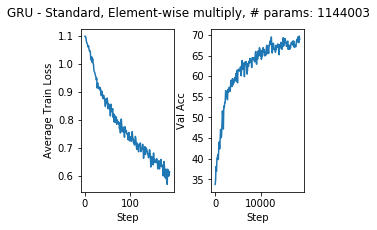

In [82]:
def get_trainable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

plot_loss_and_validation_curves(losses, xs, val_accs, "GRU - Standard, Element-wise multiply, # params: {}".format(get_trainable_parameters(model)))

In [25]:
# torch.save(model.state_dict(), "/home/vrajiv/rnn-cnn-natural-language-inference/best_rnn")

### Evaluating on MNLI

In [26]:
mnli_val = pd.read_csv('mnli_val.tsv', sep='\t')

In [27]:
sentence_length_75 = pd.Series([len(x) for x in mnli_val['sentence1']]).describe()['75%']
print("75th percentile for sentence length (in characters): {}".format(sentence_length_75))
MAX_SENTENCE_LENGTH = 40

75th percentile for sentence length (in characters): 151.0


#### Build dictionary of (sent1, sent2, label) data, by genre

In [28]:
mnli_val_dict = {}
for x in mnli_val['genre'].unique():
    filtered = mnli_val[mnli_val['genre'] == x]
    mnli_val_dict[x] = {}
    mnli_val_dict[x]["sent1s"] = list(filtered["sentence1"])
    mnli_val_dict[x]["sent2s"] = list(filtered["sentence2"])
    mnli_val_dict[x]["label"] = convert_labels_to_integers(list(filtered["label"]))

In [29]:
for x in mnli_val_dict.keys():
    print(len(mnli_val_dict[x]["sent1s"]))
    print(np.unique(mnli_val_dict[x]["label"]))
    
# quick verify
verify_order(mnli_val_dict['travel']["sent1s"], mnli_val_dict['travel']["sent2s"], mnli_val_dict['travel']["label"])

995
[0 1 2]
1005
[0 1 2]
1002
[0 1 2]
1016
[0 1 2]
982
[0 1 2]
Now open political debate flourished , especially in Calcutta where Karl Marx was much appreciated .
Now political debate died down in Calcutta especially , where Karl Marx was hated .
0


In [30]:
# for each genre, build validation set and evaluate on it. 
cnn_results = {}
model = TwoSentenceModel(emb_size = 300, hidden_size=300, num_layers=1, num_classes=3).to(device)
model.load_state_dict(torch.load("/home/vrajiv/rnn-cnn-natural-language-inference/best_rnn"))
model.eval()
for genre in mnli_val_dict.keys():
    sent1_val_indices, sent2_val_indices, val_label = data_pipeline(mnli_val_dict[genre]["sent1s"], 
                                                                    mnli_val_dict[genre]["sent2s"], 
                                                                    mnli_val_dict[genre]["label"])
    val_dataset = TwoSentencesDataset(sent1_val_indices, sent2_val_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                             batch_size=BATCH_SIZE, 
                                             collate_fn=twosentences_collate_func,
                                             #shuffle=True
                                             )
    cnn_results[genre] = test_model(val_loader, model)

for genre in mnli_val_dict.keys():
    print("Genre {} has validation accuracy: {}".format(genre, cnn_results[genre]))
    

Random seed for shuffling: 95

Verifying that the data and label match after shuffling
'You burned down my house . '
'You used matches and gasoline to commit arson . '
2
I sha n't stop you . ''
You can stop .
0

Tokenizing sentence 1 list...
done!

Tokenizing sentence 2 list... 
done!

One-hot encoding words for sentence 1 list...
done!

One-hot encoding words for sentence 2 list...
done!
Random seed for shuffling: 79

Verifying that the data and label match after shuffling
maybe adult literacy maybe you know composition writing maybe you know uh volunteering you know on a tutor line or though the even through the elementary schools for help with homework or the other part of me says is God i 've had enough kids do i really
maybe I could volunteer to help coach sports since I 've helped all my children be successful in sports
0
that 's right you can work yourself to death well i 'm sorry to hear your color did n't come out so good over the weekend
I 'm sorry it did n't turn out as plan

### 3 correct and 3 incorrect predictions

In [99]:
model = TwoSentenceModel(emb_size = 300, hidden_size=300, num_layers=1, num_classes=3).to(device)
model.load_state_dict(torch.load("/home/vrajiv/rnn-cnn-natural-language-inference/best_rnn"))
model.eval()

eval_dataset = TwoSentencesDataset(sent1_val_indices, sent2_val_indices, val_label)
eval_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=1, 
                                           collate_fn=twosentences_collate_func,
                                           #shuffle=True
                                          )

i = 0
incorrect_data = []
correct_data = []
corr_count = 0
incorr_count = 0
for data, sent1_lengths, sent2_lengths, labels in eval_loader:
        data_batch, sent1_length_batch, sent2_length_batch, label_batch = data.to(device), sent1_lengths.to(device), sent2_lengths.to(device), labels.to(device)
        outputs = F.softmax(model(data_batch, sent1_length_batch, sent2_length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.to(device)
        
        if (predicted.squeeze().item() == labels.squeeze().item() and corr_count <= 2):
            corr_count += 1
            correct_data.append(snli_val.iloc[[i]])
            print("correct: ", labels.squeeze().item())
        elif (predicted.squeeze().item() != labels.squeeze().item() and incorr_count <= 2):
            incorr_count += 1
            incorrect_data.append(snli_val.iloc[[i]])
            print("incorrect: ", labels.squeeze().item())
        i += 1
        
        if corr_count == 3 and incorr_count == 3:
            break       

correct:  1
correct:  0
incorrect:  1
incorrect:  0
correct:  2
incorrect:  2


In [94]:
for i in range(len(correct_data)):
    print(correct_data[i]["sentence1"])
    print(correct_data[i]["sentence2"])
    print(correct_data[i]["label"])
    print("\n\n")

0    Three women on a stage , one wearing red shoes...
Name: sentence1, dtype: object
0    There are two women standing on the stage
Name: sentence2, dtype: object
0    contradiction
Name: label, dtype: object



1    Four people sit on a subway two read books , o...
Name: sentence1, dtype: object
1    Multiple people are on a subway together , wit...
Name: sentence2, dtype: object
1    entailment
Name: label, dtype: object



4    Man observes a wavelength given off by an elec...
Name: sentence1, dtype: object
4    The man is examining what wavelength is given ...
Name: sentence2, dtype: object
4    entailment
Name: label, dtype: object





In [95]:
for i in range(len(incorrect_data)):
    print(incorrect_data[i]["sentence1"])
    print(incorrect_data[i]["sentence2"])
    print(incorrect_data[i]["label"])
    print("\n\n")

2    bicycles stationed while a group of people soc...
Name: sentence1, dtype: object
2    People get together near a stand of bicycles .
Name: sentence2, dtype: object
2    entailment
Name: label, dtype: object



3    Man in overalls with two horses .
Name: sentence1, dtype: object
3    a man in overalls with two horses
Name: sentence2, dtype: object
3    entailment
Name: label, dtype: object



6    Two men are listening to music through headpho...
Name: sentence1, dtype: object
6    Two men listen to music .
Name: sentence2, dtype: object
6    entailment
Name: label, dtype: object





#### Discussion

For the three correct predictions, it seems like the RNN model can find contradictions by comparing the number of objects (three women vs two women, four people vs multiple people), as well as sentences with multiple coexisting words (wavelength, given, man) and similar grammatical structures. 

For the three incorrect predictions, it seems to have trouble with different forms of verbs ("listen" vs "are listening"), and different grammatical structures ("people get together" vs "...while a group of people"). 